# CSE 164 - Spring 2024 - Assignment 2

## Instruction 

- Submit your assignments onto **Canvas** by the due date. Upload a singel `.ipynb` file with all the necessary output.
- Don't use any magic function from other libraries. You will get **no credit** if a 2D Gaussian filter function from a known library is used when you are asked to implement **2D Gaussian Filtering**.
- Don't change the input and output structure of pre-defined functions. Most coding parts can be finished with about 5-6 lines of codes. 
- Make sure you have installed required packages: `numpy, scikit-image, PIL, opencv-python, matplotlib, scipy`.
- Make your change only between `# ========== YOUR CODE STARTS HERE ==========` and `# ========== YOUR CODE ENDS HERE ==========`. This should be sufficient to implement your solution.

## Rubric

- Q1: SIFT Blob Detection (30pts)
  - Q1.1: LoG and NLoG Kernel (10pts)
  - Q1.2: NLoG Filtering (5pts)
  - Q1.3: Keypoint Detection (10pts)
  - Q1.4: De-duplication (5pts)

- Q2: Hough Transformation (20pts)

- Q3: Image Transformations & Homography (25pts)
  - Q3.1: Compute Affine Transform Matrix (5pts)
  - Q3.2: Apply Affine Transform (5pts)
  - Q3.3: Compute Homography Matrix (10pts)
  - Q3.4: Warp Using Homography (5pts)

- Q4: Camera Projection & Calibration (25pts)
  - Q4.1: Compute Projection Matrix (10pts)
  - Q4.2: Project 3D Points (10pts)
  - Visualization Output (5pts)

## Preparation
### Import the Dependencies

In [1]:
import numpy as np
import cv2
from skimage import io
from PIL import Image 
import matplotlib.pylab as plt
from scipy.ndimage import minimum_filter

### Preparation: Read Image from Urls

Image shape: (200, 150, 1)


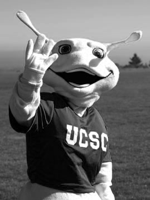

In [2]:
url = "https://news.ucsc.edu/2011/06/images/slugcloseup350.jpg"

image = np.asarray(Image.fromarray(io.imread(url)).resize((150, 200)))[:, :, :1]
print("Image shape:", image.shape)

Image.fromarray(image[:, :, 0])

## Q1: SIFT Blob Detection (30pts)

For easy visualization of a filter kernel, we first define `plot3d_on_ax` and `plot2d_on_ax`.

In [3]:
def plot3d_on_ax(matrix, ax):
    x = np.arange(0, matrix.shape[0])
    y = np.arange(0, matrix.shape[1])
    x, y = np.meshgrid(x, y)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")

    surf = ax.plot_surface(x, y, matrix, cmap='viridis')
    return surf

Here is a dummy "wave" kernel just for demonstrating the effect of `plot3d_on_ax`.

/tmp/ipykernel_80338/3672302910.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


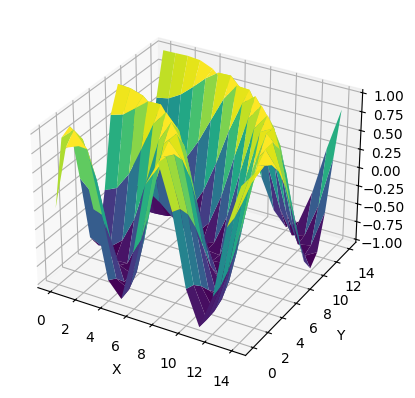

In [4]:
def create_dummy_kernel():
    x = np.arange(0, 15)
    y = np.arange(0, 15)
    x, y = np.meshgrid(x, y)
    dummy_kernel = np.sin(np.sqrt(x ** 2 + y ** 2))

    return dummy_kernel

dummy_kernel = create_dummy_kernel()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plot3d_on_ax(dummy_kernel, ax)

fig.show()

In [5]:
def plot2d_on_ax(matrix, ax):
    y = np.arange(0, matrix.shape[0])
    x = np.arange(0, matrix.shape[1])
    x, y = np.meshgrid(x, y)

    ax.set_xlabel("Y")
    ax.set_ylabel("X")
    ax.invert_yaxis()
    contour = ax.contourf(x, y, matrix, 100, cmap='viridis')
    return contour

/tmp/ipykernel_80338/3500466360.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


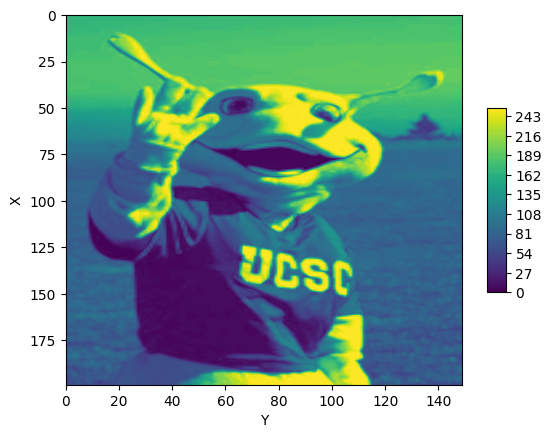

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
contour = plot2d_on_ax(image.astype("float").mean(-1), ax)
fig.colorbar(contour, ax=ax, shrink=0.5, aspect=10)

fig.show()

### Q1.1 LoG and NLoG Kernel (10pts)
Since the formula for LoG kernel is complicated, we can start with a gaussian kernel then apply a 3x3 discrete Laplacian operator to approximate the second derivative. See the Page 64 of the slide for Lecture 4 (Edge Detection) for more details about the Laplacian operator.

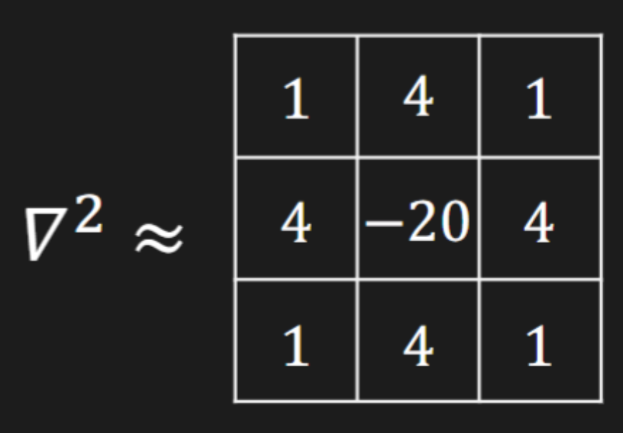

This `build_gaussian_kernel` is provided in case you didn't get this right in the Assignment 1.

In [7]:
def build_gaussian_kernel(kernel_size, std):
    # kernel_size: kernel size. It should be odd and positive
    # std: standard deviation in gaussian distribution
    # return: output log_kernel

    kernel_range = np.arange(-kernel_size // 2 + 1., kernel_size // 2 + 1.)
    x, y = np.meshgrid(kernel_range, kernel_range)
    gaussian_kernel = np.exp(-(x ** 2 + y ** 2) / (2 * std ** 2)) / (2 * np.pi * std ** 2)
    gaussian_kernel /= gaussian_kernel.sum()

    return gaussian_kernel

In [8]:
gaussian_kernel_std1 = build_gaussian_kernel(25, 1.5)
gaussian_kernel_std2 = build_gaussian_kernel(25, 2.0)
gaussian_kernel_std3 = build_gaussian_kernel(25, 2.5)

/tmp/ipykernel_80338/147509879.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


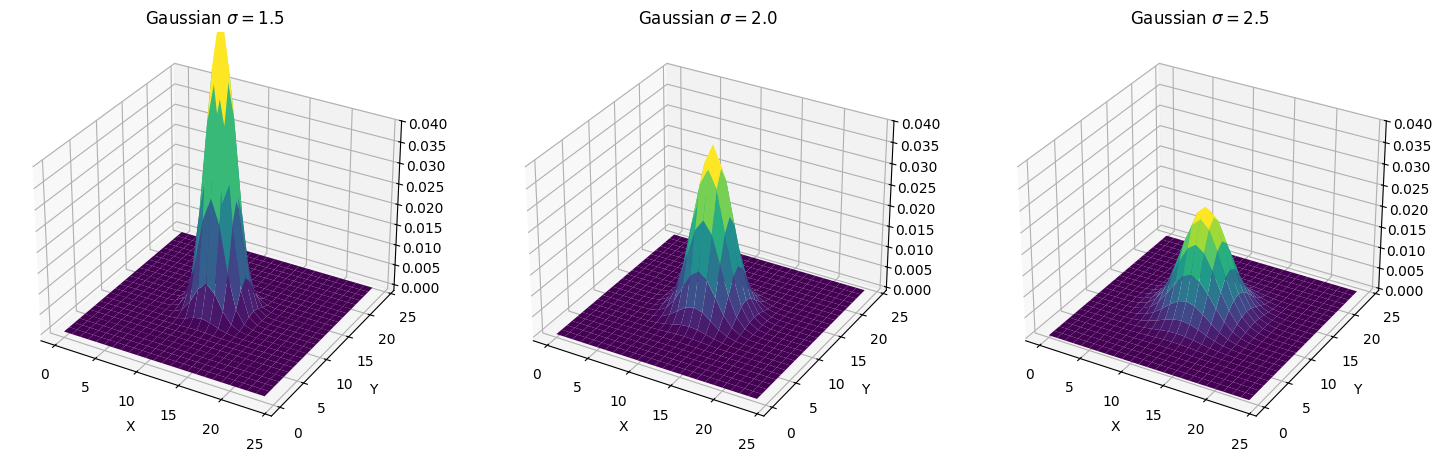

In [9]:
fig = plt.figure(figsize=(6 * 3, 6 * 1))
axs = fig.subplots(1, 3, subplot_kw=dict(projection='3d'))
plot3d_on_ax(gaussian_kernel_std1, axs[0])
axs[0].set_title("Gaussian $\sigma = 1.5$")
axs[0].set_zlim3d(zmax=0.04)

plot3d_on_ax(gaussian_kernel_std2, axs[1])
axs[1].set_title("Gaussian $\sigma = 2.0$")
axs[1].set_zlim3d(zmax=0.04)

plot3d_on_ax(gaussian_kernel_std3, axs[2])
axs[2].set_title("Gaussian $\sigma = 2.5$")
axs[2].set_zlim3d(zmax=0.04)

fig.show()

In [10]:
# 5pts
def build_log_kernel(kernel_size, std):
    # kernel_size: kernel size. It should be odd and positive
    # std: standard deviation in gaussian distribution
    # return: output log_kernel

    gaussian_kernel = build_gaussian_kernel(kernel_size, std)

    # You are required to alter this `gaussian_kernel` to get the laplacian of gaussian kernel.
    # Treat `gaussian_kernel` as if it is an image,
    # and use cv2.filter2D to apply laplacian filtering on the `gaussian_kernel`.
    # ========== YOUR CODE STARTS HERE ==========
    log_kernel = cv2.filter2D(gaussian_kernel, -1, cv2.Laplacian(np.eye(1), cv2.CV_64F))
    # ========== YOUR CODE STARTS HERE ==========

    return log_kernel


# 5pts
def build_nlog_kernel(kernel_size, std):
    # kernel_size: kernel size. It should be odd and positive
    # std: standard deviation in gaussian distribution
    # return: output log_kernel

    log_kernel = build_log_kernel(kernel_size, std)

    # You are required to alter this `log_kernel` to get the normlized laplacian of gaussian kernel.
    # ========== YOUR CODE STARTS HERE ==========
    nlog_kernel = log_kernel - np.mean(log_kernel)
    # ========== YOUR CODE STARTS HERE ==========

    return nlog_kernel

In [11]:
log_kernel_std1 = build_log_kernel(25, 1.5)
log_kernel_std2 = build_log_kernel(25, 2.0)
log_kernel_std3 = build_log_kernel(25, 2.5)

nlog_kernel_std1 = build_nlog_kernel(25, 1.5)
nlog_kernel_std2 = build_nlog_kernel(25, 2.0)
nlog_kernel_std3 = build_nlog_kernel(25, 2.5)

/tmp/ipykernel_80338/3763015192.py:41: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


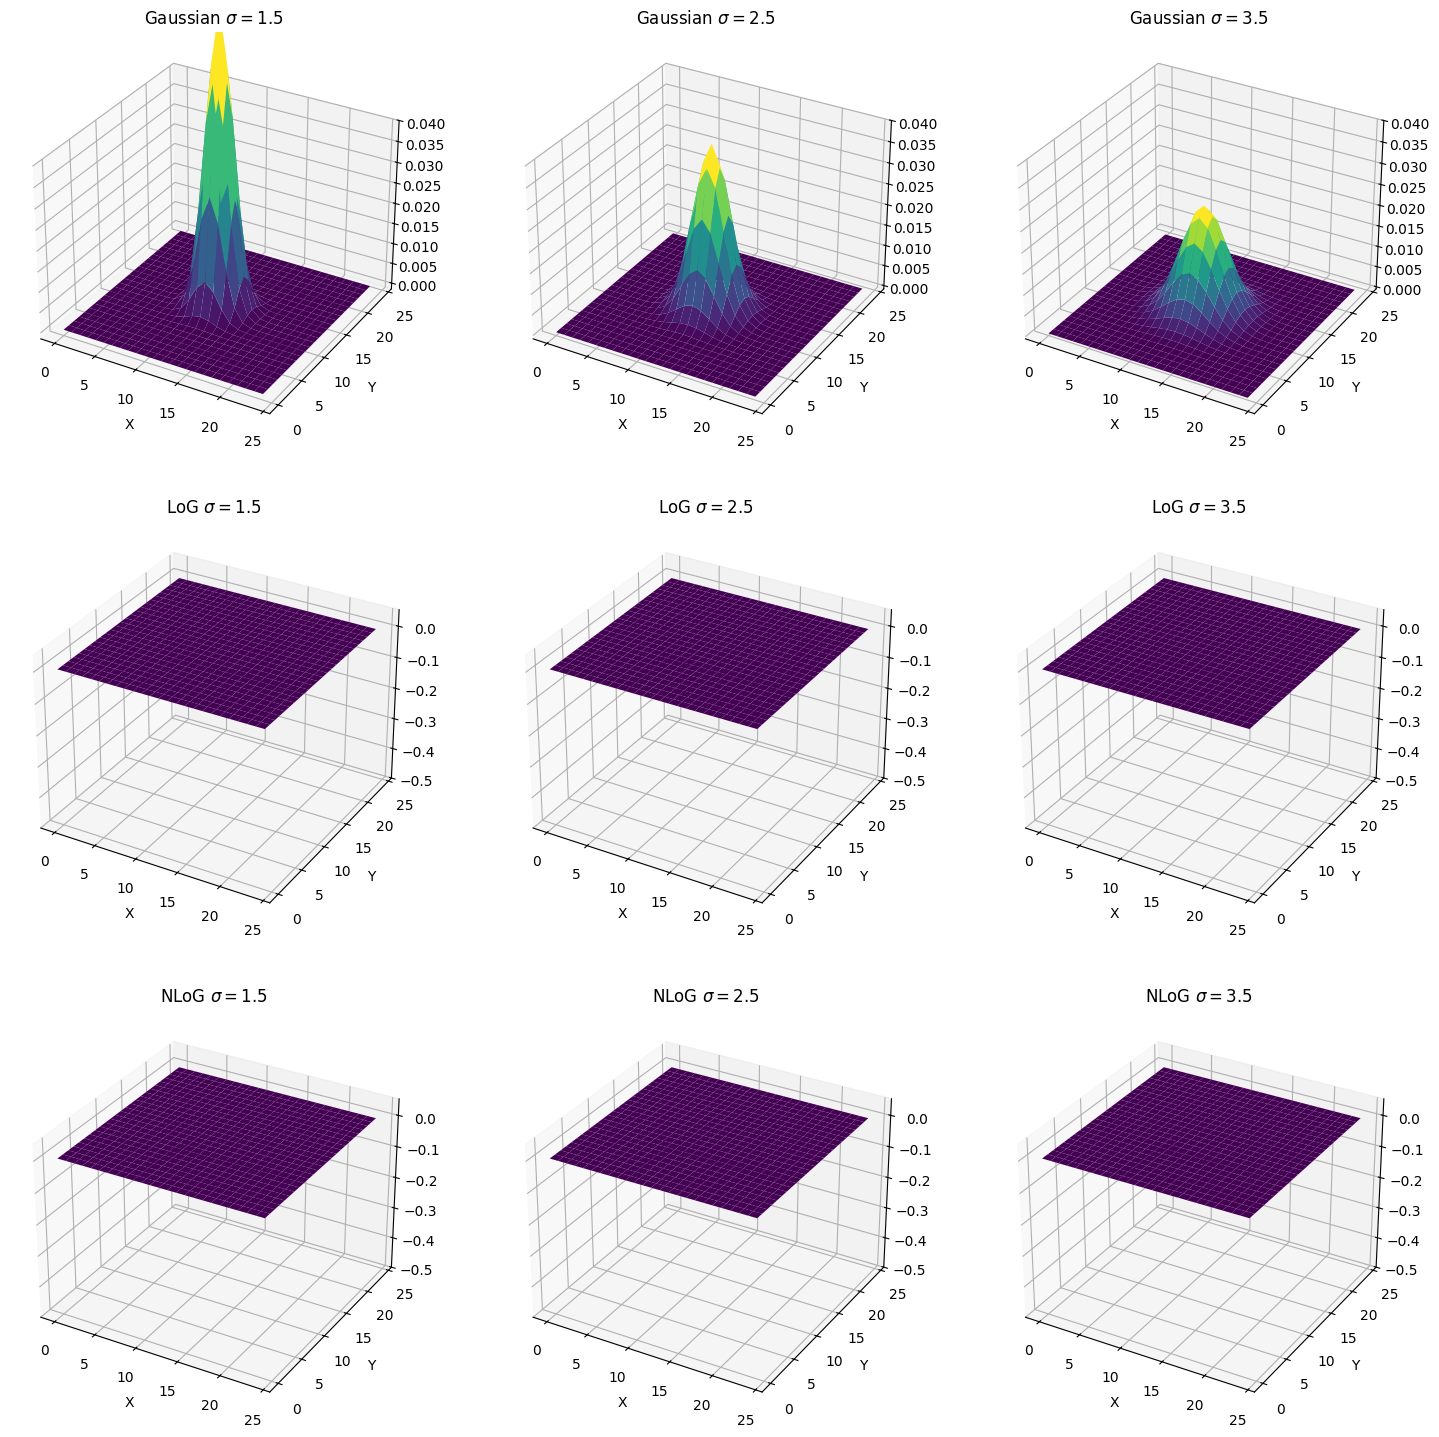

In [12]:
fig = plt.figure(figsize=(6 * 3, 6 * 3))
axs = fig.subplots(3, 3, subplot_kw=dict(projection='3d'))

plot3d_on_ax(gaussian_kernel_std1, axs[0][0])
axs[0][0].set_title("Gaussian $\sigma = 1.5$")
axs[0][0].set_zlim3d(zmax=0.04)

plot3d_on_ax(gaussian_kernel_std2, axs[0][1])
axs[0][1].set_title("Gaussian $\sigma = 2.5$")
axs[0][1].set_zlim3d(zmax=0.04)

plot3d_on_ax(gaussian_kernel_std3, axs[0][2])
axs[0][2].set_title("Gaussian $\sigma = 3.5$")
axs[0][2].set_zlim3d(zmax=0.04)

plot3d_on_ax(log_kernel_std1, axs[1][0])
axs[1][0].set_title("LoG $\sigma = 1.5$")
axs[1][0].set_zlim3d(zmin=-0.5)

plot3d_on_ax(log_kernel_std2, axs[1][1])
axs[1][1].set_title("LoG $\sigma = 2.5$")
axs[1][1].set_zlim3d(zmin=-0.5)

plot3d_on_ax(log_kernel_std3, axs[1][2])
axs[1][2].set_title("LoG $\sigma = 3.5$")
axs[1][2].set_zlim3d(zmin=-0.5)

plot3d_on_ax(nlog_kernel_std1, axs[2][0])
axs[2][0].set_title("NLoG $\sigma = 1.5$")
axs[2][0].set_zlim3d(zmin=-0.5)

plot3d_on_ax(nlog_kernel_std2, axs[2][1])
axs[2][1].set_title("NLoG $\sigma = 2.5$")
axs[2][1].set_zlim3d(zmin=-0.5)

plot3d_on_ax(nlog_kernel_std3, axs[2][2])
axs[2][2].set_title("NLoG $\sigma = 3.5$")
axs[2][2].set_zlim3d(zmin=-0.5)


fig.show()

### Q1.2 NLoG Filtering (5pts)
Similar to Assignment 1, use `cv2.filter2D` to filter the image with a NLoG kernel built with `build_nlog_kernel`.

<!-- Since the input is a 3-channel RGB image, we need to get the **channel-wise averaged** value per pixel after `cv2.filter2D` to get the final result. -->

In [40]:
def nlog_filter(img, kernel_size, std):
    # `image`: input image. Shape: (H, W, 3)
    # kernel_size: kernel size. It should be odd and positive
    # std: standard deviation in gaussian distribution
    # return: output image. Shape: (H, W)

    assert isinstance(kernel_size, int) and kernel_size % 2

    # ========== YOUR CODE STARTS HERE ==========
 # img: already grayscale float image, shape (H, W)
    
    img = img.astype(np.float32)  # ensure float32 for filter2D

    # Build normalized Laplacian of Gaussian kernel
    nlog_kernel = build_nlog_kernel(kernel_size, std)

    # Apply the filter
    filtered_img = cv2.filter2D(img, -1, nlog_kernel)
    # ========== YOUR CODE ENDS HERE ==========

    return img


In [42]:
stds = list(range(10, 20))

image_nloged_dict = {
    std: nlog_filter(image.astype("float"), kernel_size=127, std=std)
    for std in stds
}

TypeError: Input z must be 2D, not 3D

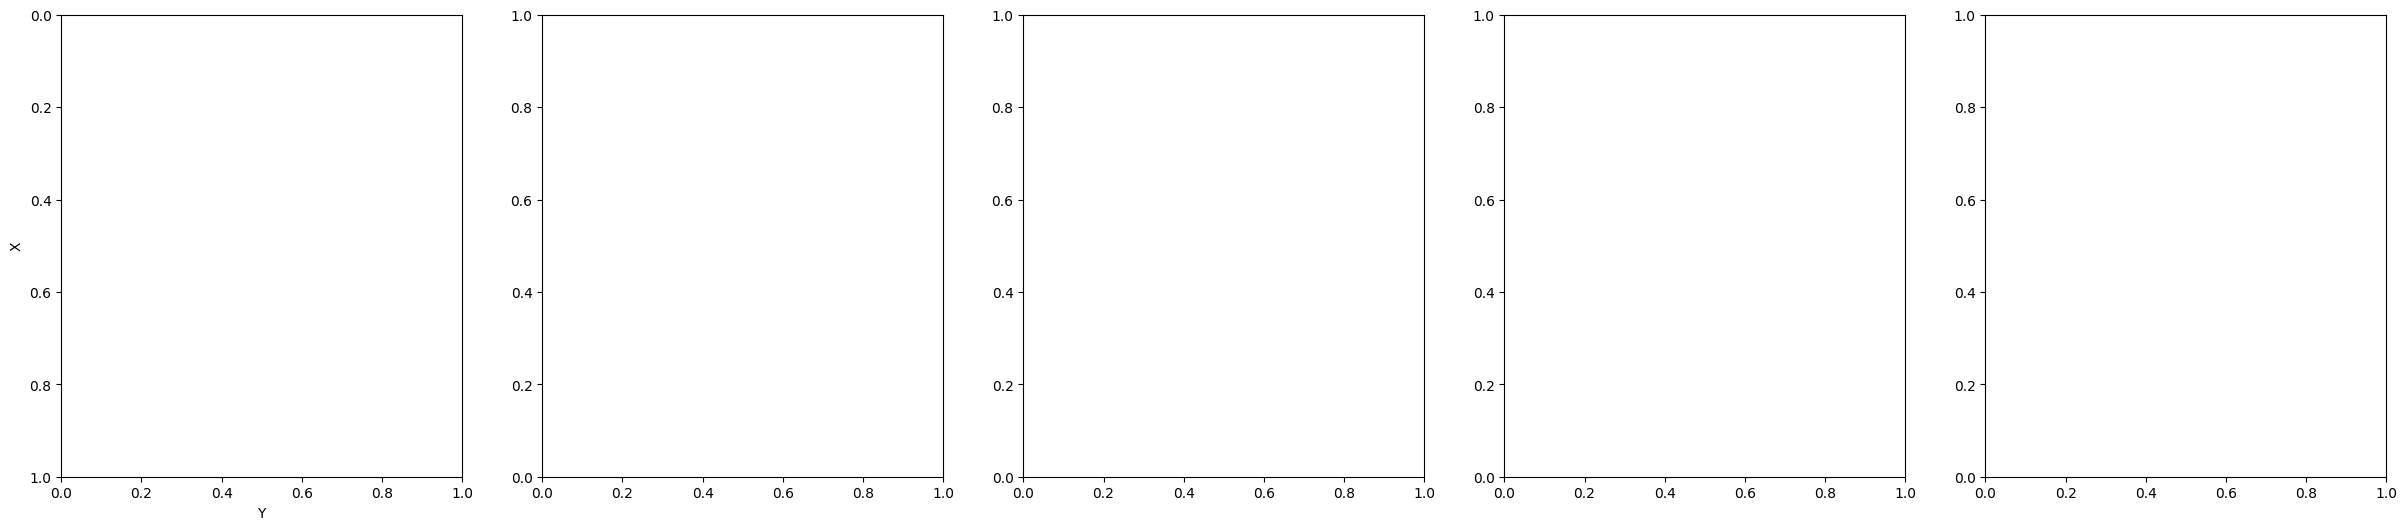

In [43]:
fig = plt.figure(figsize=(6 * (len(stds) // 2), 6 * 1))
axs = fig.subplots(1, len(stds) // 2)

for ax, std in zip(axs, stds[::2]):
    contour = plot2d_on_ax(image_nloged_dict[std], ax)
    ax.set_title(f"Gaussian $\sigma = {std}$")
    fig.colorbar(contour, ax=ax, shrink=0.5, aspect=10)

fig.show()

### Q1.3 Keypoint Detection (10pts)

Find all the local minima below an threshold. No need to remove repeated detections at the same location for now.

In [ ]:
def detect_keypoints(image_nloged_dict, threshold=-5):
    # `image_nloged_dict`: a dict mapping a std to the corresponding image after NLoG.
    # threshold: threshold for removing weak local minima
    # return: a list of tuples.Each tuple is a quadruple (x, y, std, value) storing
    #         the x coordinate, y coordinate, corresponding std and the minima value.


    keypoints = []
    for std, image_nloged in image_nloged_dict.items():
        # Find all the local minima within a 20x20 window.
        # `local_minima` is the binary mask with the same size of `image_nloged`.
        # 0: is not a local minima
        # 1: is a local minima
        local_minima = (image_nloged <= minimum_filter(image_nloged, size=20))

        # Filter the local minima with threshold and store the result in keypoints
        # ========== YOUR CODE STARTS HERE ==========
        pass
        # ========== YOUR CODE ENDS HERE ==========
    return keypoints

In [ ]:
keypoints = detect_keypoints(image_nloged_dict, threshold=-2)

### Q1.4 De-duplication (5pts)

For detections at the same location, only keep ones with the lowest values.

In [ ]:
def dedup_keypoints(keypoints):
    # keypoints: a list of tuples from `detect_keypoints`
    # return: filtered keypoints with the same format as `keypoints`

    # ========== YOUR CODE STARTS HERE ==========
    pass
    # ========== YOUR CODE ENDS HERE ==========
    return filtered

In [ ]:
filtered_keypoints = dedup_keypoints(keypoints)

In [ ]:
len(keypoints), len(filtered_keypoints)

Since SIFT is very parameter-sensitive, it can expected that your result doesn't seem to make sense.

Here is the reference result you should have for $\sigma = 11, 12, 13$.

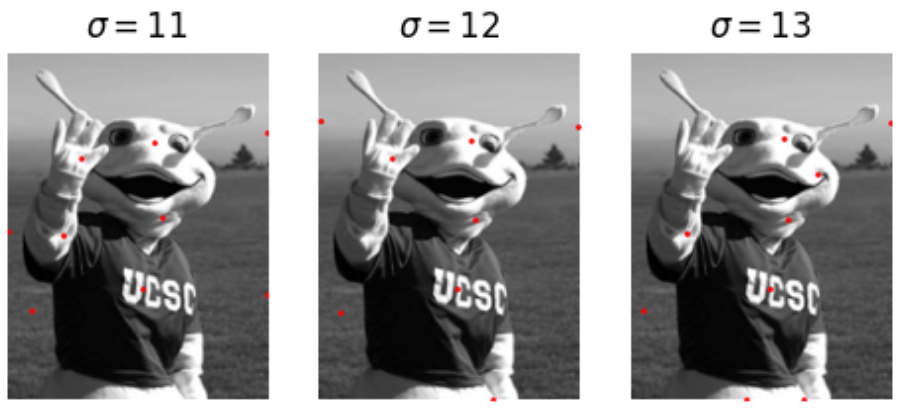

In [ ]:
fig, axes = plt.subplots(1, len(stds), figsize=(20, 8))
for ax, sigma in zip(axes, stds):
    ky = np.asarray([(x, y) for (x, y, std, _) in filtered_keypoints if std == sigma])
    ax.imshow(image, cmap="gray")
    if ky.shape[0] > 0:
        ax.scatter(ky[:, 1], ky[:, 0], c='r', s=1)
    ax.axis('off')
    ax.set_title(f'$\sigma={sigma}$')
plt.show()

## Q2: Hough Transformation (20pts)

In [ ]:
points = np.asarray([(1, 6), (9, 34), (21, 62), (29, 100), (40, 130)])

In [ ]:
plt.scatter(*zip(*points), color='red')
plt.xlim(0, 50)
plt.ylim(0, 150)
plt.show()

Use Hough Transformation to estimate the $r$ and $\theta$ in $r = x \text{cos}(\theta) + y \text{sin}(\theta)$

In [ ]:
def hough_transform(points):
    # points: a numpy array of coordinates
    # return: accumulator, best_r, best_theta
    #         accumulator: a 2D accumulator matrix.
    #                      The first dimension is for rs and the second one is for thetas.
    #         best_r, best_theta: the best estimation of r and theta

    max_dist = int(np.max(np.abs(points)))
    thetas = np.deg2rad(np.arange(-90, 90, 1))  # available thetas for voting
    rs = np.arange(-max_dist, max_dist, 0.1)  # available rs for voting

    # 5pts
    # build the `accumulator`
    # ========== YOUR CODE STARTS HERE ==========
    pass
    # ========== YOUR CODE ENDS HERE ==========
    
    # 10pts
    # vote in `accumlator`
    # ========== YOUR CODE STARTS HERE ==========
    pass
    # ========== YOUR CODE ENDS HERE ==========

    # 5pts
    # select the best theta and r from `thetas` and `rs` according to `accumulator`
    # ========== YOUR CODE STARTS HERE ==========
    pass
    # ========== YOUR CODE ENDS HERE ==========

    return accumulator, best_r, best_theta

In [ ]:
accumulator, best_r, best_theta = hough_transform(points)
print(best_r, best_theta)

In [ ]:
plt.scatter(points[:, 0], points[:, 1], color='red')
x_vals = np.array([0, 100])
y_vals = (best_r - x_vals * np.cos(best_theta)) / np.sin(best_theta)
plt.plot(x_vals, y_vals, '-b')
plt.xlim(0, 50)
plt.ylim(0, 150)
plt.show()

## Q3: Image Transformations & Homography (25pts)

In this problem, you will implement key components of affine and homography transformations, and apply them to warp an image. 

### Q3.1: Compute Affine Transform Matrix (5pts)

In [ ]:
import numpy as np

def compute_affine(src, dst):
    """Compute the 2x3 affine transform matrix from 3 source and 3 destination points."""
    # src, dst: (3, 2) arrays
    # ========== YOUR CODE STARTS HERE ==========
    pass
    # ========== YOUR CODE ENDS HERE ==========


### Q3.2: Apply Affine Transform (5pts)

In [ ]:
from skimage.transform import warp

def warp_affine(img, affine_matrix, output_shape):
    """Warp an image using a 2x3 affine matrix."""
    from skimage.transform import AffineTransform
    # ========== YOUR CODE STARTS HERE ==========
    pass
    # ========== YOUR CODE ENDS HERE ==========


### Q3.3: Compute Homography (10pts)

In [ ]:
def compute_homography(src, dst):
    """Compute a 3x3 homography matrix from 4 pairs of points."""
    # ========== YOUR CODE STARTS HERE ==========
    pass
    # ========== YOUR CODE ENDS HERE ==========


### Q3.4: Warp Using Homography (5pts)

In [ ]:
from skimage.transform import ProjectiveTransform

def warp_homography(img, H, output_shape):
    """Warp image with a 3x3 homography matrix."""
    # ========== YOUR CODE STARTS HERE ==========
    pass
    # ========== YOUR CODE ENDS HERE ==========


## Q4: Camera Projection & Calibration (25pts)

You will implement the forward projection from 3D world coordinates to 2D pixel coordinates using intrinsic and extrinsic camera parameters.


### Q4.1: Compute Projection Matrix (10pts)

In [ ]:
def compute_projection_matrix(K, R, t):
    """Compute the 3x4 projection matrix P = K [R|t]."""
    # ========== YOUR CODE STARTS HERE ==========
    pass
    # ========== YOUR CODE ENDS HERE ==========


### Q4.2: Project 3D Points (10pts)

In [ ]:
def project_points(P, points_3d):
    """Project 3D points (N, 3) to 2D pixel coordinates using projection matrix P."""
    # ========== YOUR CODE STARTS HERE ==========
    pass
    # ========== YOUR CODE ENDS HERE ==========


In [ ]:
# Q3.2: Visualization Test for warp_affine
from matplotlib import pyplot as plt
from skimage import io
from PIL import Image
import numpy as np

url = "https://news.ucsc.edu/2011/06/images/slugcloseup350.jpg"
image = np.asarray(Image.fromarray(io.imread(url)).resize((150, 200)))[:, :, :1] / 255.0

# Define affine transform (e.g., translation + scale)
src = np.array([[0, 0], [0, 100], [100, 0]])
dst = np.array([[10, 20], [10, 120], [110, 20]])
affine_mat = compute_affine(src, dst)
warped = warp_affine(image, affine_mat, output_shape=image.shape[:2])

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(image[:, :, 0], cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Warped (Affine)")
plt.imshow(warped[:, :, 0], cmap='gray')
plt.show()


In [ ]:
# Q3.4: Visualization Test for warp_homography
# Four corners of a square to a trapezoid
src = np.array([[0, 0], [0, 100], [100, 100], [100, 0]])
dst = np.array([[10, 10], [20, 110], [90, 90], [110, 20]])
H = compute_homography(src, dst)
warped_h = warp_homography(image, H, output_shape=image.shape[:2])

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(image[:, :, 0], cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Warped (Homography)")
plt.imshow(warped_h[:, :, 0], cmap='gray')
plt.show()


In [ ]:
# Q4.2: Visualization Test for project_points
from mpl_toolkits.mplot3d import Axes3D

# Define intrinsic matrix
K = np.array([[100, 0, 75],
              [0, 100, 100],
              [0,   0,   1]])

# Identity rotation, small translation
R = np.eye(3)
t = np.array([0, 0, 500])

P = compute_projection_matrix(K, R, t)

# 3D points: grid in front of the camera
x, y = np.meshgrid(np.linspace(-100, 100, 10), np.linspace(-100, 100, 10))
z = np.zeros_like(x)
points_3d = np.stack([x.ravel(), y.ravel(), z.ravel()], axis=1)

projected = project_points(P, points_3d)

plt.figure(figsize=(5, 5))
plt.scatter(projected[:, 0], projected[:, 1], c='blue')
plt.title("Projected 3D Points")
plt.gca().invert_yaxis()
plt.axis('equal')
plt.grid(True)
plt.show()
